In [101]:
# PRODUCT SUBSTITUTABILITY ANALYSIS - CLEAN VERSION
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, precision_score, fbeta_score
import os

print("=== PRODUCT SUBSTITUTABILITY ANALYSIS ===")
print("Loading data and setting up analysis...")

=== PRODUCT SUBSTITUTABILITY ANALYSIS ===
Loading data and setting up analysis...


In [102]:
# 1. LOAD DATA
# Load edade.xlsx (ground truth)
edade_df = pd.read_excel('../NewData/edade.xlsx')
print(f"Loaded edade.xlsx: {edade_df.shape[0]} product pairs")
print(f"Columns: {edade_df.columns.tolist()}")

# Create ground truth mapping
ground_truth = {}
for _, row in edade_df.iterrows():
    p1, p2 = row['product_id1'], row['product_id2']
    label = 1 if row['substitutability'] == 'Yes' else 0
    ground_truth[(p1, p2)] = label
    ground_truth[(p2, p1)] = label  # bidirectional

print(f"Created ground truth mapping for {len(ground_truth)} product pairs")
print(f"Substitutability distribution: {edade_df['substitutability'].value_counts().to_dict()}")

Loaded edade.xlsx: 19900 product pairs
Columns: ['product_id1', 'product_id2', 'substitution_score', 'substitutability', 'p1_cat', 'p2_cat']
Created ground truth mapping for 39800 product pairs
Substitutability distribution: {'No': 19516, 'Yes': 384}


In [103]:
# 2. WEIGHTED F1 SCORE FUNCTION (via F-beta; recall emphasis set by beta)
def weighted_f1_score(y_true, y_pred, recall_weight=0.7, precision_weight=0.3,
                      average='binary', zero_division=0):
    # Map desired weights to beta: w_R : w_P  ==  beta^2 : 1
    if precision_weight <= 0 or recall_weight <= 0:
        raise ValueError("precision_weight and recall_weight must be > 0 for F-beta.")
    beta = (recall_weight / precision_weight) ** 0.5
    return fbeta_score(y_true, y_pred, beta=beta, average=average, zero_division=zero_division)

print("Created weighted F1 (via F-beta) with Recall: 0.7, Precision: 0.3")


Created weighted F1 (via F-beta) with Recall: 0.7, Precision: 0.3


In [104]:
# 3. FIND OPTIMAL THRESHOLD FOR EACH STORE
def find_optimal_threshold(store_file, thresholds, ground_truth_map):
    """Find optimal threshold for a store using weighted F1 score"""
    # Load store data
    store_df = pd.read_csv(store_file)
    
    # Get ground truth labels for pairs in this store
    y_true, y_scores = [], []
    for _, row in store_df.iterrows():
        pair = (row['product_id1'], row['product_id2'])
        if pair in ground_truth_map:
            y_true.append(ground_truth_map[pair])
            y_scores.append(row['substitute_score'])
    
    if len(y_true) == 0:
        return None, {}
    
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Test each threshold
    best_threshold = None
    best_score = 0
    results = {}
    
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        weighted_f1 = weighted_f1_score(y_true, y_pred, recall_weight=0.7, precision_weight=0.3)
        recall = recall_score(y_true, y_pred, zero_division=0)
        precision = precision_score(y_true, y_pred, zero_division=0)
        
        results[threshold] = {
            'weighted_f1': weighted_f1,
            'recall': recall,
            'precision': precision
        }
        
        if weighted_f1 > best_score:
            best_score = weighted_f1
            best_threshold = threshold
    
    return best_threshold, results

print("Created threshold optimization function")


Created threshold optimization function


In [105]:
# 4. PROCESS ALL STORES (S001-S010)
thresholds = [round(x, 2) for x in np.arange(0.1, 0.91, 0.01)]
stores = [f'S{i:03d}' for i in range(1, 11)]

results = {}
processed_stores = {}

print(f"Processing {len(stores)} stores with thresholds {thresholds[0]}-{thresholds[-1]}...")

for store in stores:
    store_file = f'../NewData/StoresLevel/{store}.csv'

    if os.path.exists(store_file):
        # Find optimal threshold
        optimal_threshold, performance = find_optimal_threshold(store_file, thresholds, ground_truth)
        
        if optimal_threshold is not None:
            # Load and categorize store data
            store_df = pd.read_csv(store_file)
            store_df['substitutability_category'] = store_df['substitute_score'].apply(
                lambda score: 'Yes' if score >= optimal_threshold else 'No'
            )
            store_df['optimal_threshold'] = optimal_threshold
            
            # Save results
            output_file = f'../NewData/StoresLevel/{store}_categorized.csv'
            store_df.to_csv(output_file, index=False)
            
            # Store results
            results[store] = {
                'threshold': optimal_threshold,
                'performance': performance[optimal_threshold]
            }
            processed_stores[store] = store_df
            
            print(f"{store}: threshold={optimal_threshold:.2f}, weighted_f1={performance[optimal_threshold]['weighted_f1']:.3f}")
        else:
            print(f"{store}: No ground truth data available")
    else:
        print(f"{store}: File not found")

print(f"\nSuccessfully processed {len(processed_stores)} stores")


Processing 10 stores with thresholds 0.1-0.9...
S001: threshold=0.79, weighted_f1=0.932
S002: threshold=0.79, weighted_f1=0.927
S003: threshold=0.79, weighted_f1=0.922
S004: threshold=0.79, weighted_f1=0.935
S005: threshold=0.79, weighted_f1=0.937
S006: threshold=0.79, weighted_f1=0.927
S007: threshold=0.79, weighted_f1=0.935
S008: threshold=0.79, weighted_f1=0.927
S009: threshold=0.79, weighted_f1=0.927
S010: threshold=0.79, weighted_f1=0.919

Successfully processed 10 stores


In [106]:
# 5. SUMMARY ANALYSIS
if processed_stores:
    # Create summary dataframe
    summary_data = []
    for store, data in results.items():
        perf = data['performance']
        summary_data.append({
            'store': store,
            'optimal_threshold': data['threshold'],
            'weighted_f1': perf['weighted_f1'],
            'recall': perf['recall'],
            'precision': perf['precision']
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    print("=== OPTIMIZATION RESULTS ===")
    print(summary_df.round(3))
    
    print(f"\n=== SUMMARY STATISTICS ===")
    print(f"Average optimal threshold: {summary_df['optimal_threshold'].mean():.3f}")
    print(f"Average weighted F1 score: {summary_df['weighted_f1'].mean():.3f}")
    print(f"Average recall: {summary_df['recall'].mean():.3f}")
    print(f"Average precision: {summary_df['precision'].mean():.3f}")
    
    # Save summary
    summary_df.to_csv('substitutability_optimization_summary.csv', index=False)
    print(f"\nSummary saved to: substitutability_optimization_summary.csv")
else:
    print("No stores were successfully processed")


=== OPTIMIZATION RESULTS ===
  store  optimal_threshold  weighted_f1  recall  precision
0  S001               0.79        0.932   0.946      0.902
1  S002               0.79        0.927   0.961      0.858
2  S003               0.79        0.922   0.956      0.851
3  S004               0.79        0.935   0.956      0.889
4  S005               0.79        0.937   0.957      0.894
5  S006               0.79        0.927   0.947      0.883
6  S007               0.79        0.935   0.949      0.905
7  S008               0.79        0.927   0.949      0.879
8  S009               0.79        0.927   0.972      0.837
9  S010               0.79        0.919   0.954      0.848

=== SUMMARY STATISTICS ===
Average optimal threshold: 0.790
Average weighted F1 score: 0.929
Average recall: 0.955
Average precision: 0.875

Summary saved to: substitutability_optimization_summary.csv


In [107]:
# 6. CATEGORIZATION ANALYSIS
if processed_stores:
    print("=== CATEGORIZATION RESULTS ===")
    
    # Overall analysis
    all_data = pd.concat(processed_stores.values(), ignore_index=True)
    category_counts = all_data['substitutability_category'].value_counts()
    
    print(f"\nOverall Distribution:")
    for category, count in category_counts.items():
        percentage = (count / len(all_data)) * 100
        print(f"  {category}: {count:,} pairs ({percentage:.1f}%)")
    
    print(f"\nPer-Store Distribution:")
    for store, store_df in processed_stores.items():
        threshold = results[store]['threshold']
        categories = store_df['substitutability_category'].value_counts()
        print(f"\n{store} (threshold: {threshold:.2f}):")
        for category, count in categories.items():
            percentage = (count / len(store_df)) * 100
            print(f"  {category}: {count:,} ({percentage:.1f}%)")
    
    print(f"\nTotal product pairs analyzed: {len(all_data):,}")
else:
    print("No data available for categorization analysis")


=== CATEGORIZATION RESULTS ===

Overall Distribution:
  No: 174,487 pairs (97.9%)
  Yes: 3,794 pairs (2.1%)

Per-Store Distribution:

S001 (threshold: 0.79):
  No: 17,400 (97.9%)
  Yes: 366 (2.1%)

S002 (threshold: 0.79):
  No: 18,127 (97.8%)
  Yes: 401 (2.2%)

S003 (threshold: 0.79):
  No: 18,311 (97.8%)
  Yes: 410 (2.2%)

S004 (threshold: 0.79):
  No: 18,139 (97.9%)
  Yes: 389 (2.1%)

S005 (threshold: 0.79):
  No: 16,672 (98.0%)
  Yes: 348 (2.0%)

S006 (threshold: 0.79):
  No: 17,400 (97.9%)
  Yes: 366 (2.1%)

S007 (threshold: 0.79):
  No: 17,586 (97.9%)
  Yes: 369 (2.1%)

S008 (threshold: 0.79):
  No: 16,314 (98.0%)
  Yes: 339 (2.0%)

S009 (threshold: 0.79):
  No: 17,349 (97.7%)
  Yes: 417 (2.3%)

S010 (threshold: 0.79):
  No: 17,189 (97.8%)
  Yes: 389 (2.2%)

Total product pairs analyzed: 178,281


In [108]:
# 7. CONFUSION MATRIX ANALYSIS FOR THRESHOLD 0.79
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("=== CONFUSION MATRIX ANALYSIS (Threshold: 0.79) ===")
print("Importing visualization libraries...")


=== CONFUSION MATRIX ANALYSIS (Threshold: 0.79) ===
Importing visualization libraries...


In [109]:
def create_confusion_matrix_for_store(store_name, threshold=0.79):
    """Create and display confusion matrix for a specific store"""

    # Load store data
    store_file = f'../NewData/StoresLevel/{store_name}.csv'
    if not os.path.exists(store_file):
        print(f"Store file not found: {store_file}")
        return None
    
    store_df = pd.read_csv(store_file)
    
    # Get ground truth labels and predictions for this store
    y_true, y_pred = [], []
    
    for _, row in store_df.iterrows():
        pair = (row['product_id1'], row['product_id2'])
        if pair in ground_truth:
            y_true.append(ground_truth[pair])
            prediction = 1 if row['substitute_score'] >= threshold else 0
            y_pred.append(prediction)
    
    if len(y_true) == 0:
        print(f"No ground truth data available for {store_name}")
        return None
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    weighted_f1 = weighted_f1_score(y_true, y_pred, recall_weight=0.7, precision_weight=0.3)
    
    return {
        'store': store_name,
        'confusion_matrix': cm,
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'weighted_f1_score': weighted_f1,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp,
            'total_pairs': len(y_true)
        }
    }

print("Created confusion matrix function")


Created confusion matrix function


In [110]:
# Generate confusion matrices for all stores S001-S010
stores_to_analyze = [f'S{i:03d}' for i in range(1, 11)]
threshold = 0.79

print(f"Generating confusion matrices for stores S001-S010 using threshold {threshold}")
print("=" * 80)

# Store results for summary
all_store_results = []

for store in stores_to_analyze:
    print(f"\n--- {store} ---")
    result = create_confusion_matrix_for_store(store, threshold)
    
    if result:
        all_store_results.append(result)
        cm = result['confusion_matrix']
        metrics = result['metrics']
        
        # Display confusion matrix
        print(f"Confusion Matrix:")
        print(f"                 Predicted")
        print(f"                No    Yes")
        print(f"Actual    No   {cm[0,0]:4d}  {cm[0,1]:4d}")
        print(f"         Yes   {cm[1,0]:4d}  {cm[1,1]:4d}")
        
        # Display metrics
        print(f"\nMetrics:")
        print(f"  Accuracy:  {metrics['accuracy']:.3f}")
        print(f"  Precision: {metrics['precision']:.3f}")
        print(f"  Recall:    {metrics['recall']:.3f}")
        print(f"  weighted_f1-Score:  {metrics['weighted_f1_score']:.3f}")
        print(f"  Total pairs with ground truth: {metrics['total_pairs']:,}")
    else:
        print(f"Could not generate confusion matrix for {store}")

print(f"\n{'='*80}")
print(f"Successfully generated confusion matrices for {len(all_store_results)} stores")


Generating confusion matrices for stores S001-S010 using threshold 0.79

--- S001 ---
Confusion Matrix:
                 Predicted
                No    Yes
Actual    No   17381    36
         Yes     19   330

Metrics:
  Accuracy:  0.997
  Precision: 0.902
  Recall:    0.946
  weighted_f1-Score:  0.932
  Total pairs with ground truth: 17,766

--- S002 ---
Confusion Matrix:
                 Predicted
                No    Yes
Actual    No   18113    57
         Yes     14   344

Metrics:
  Accuracy:  0.996
  Precision: 0.858
  Recall:    0.961
  weighted_f1-Score:  0.927
  Total pairs with ground truth: 18,528

--- S003 ---
Confusion Matrix:
                 Predicted
                No    Yes
Actual    No   18295    61
         Yes     16   349

Metrics:
  Accuracy:  0.996
  Precision: 0.851
  Recall:    0.956
  weighted_f1-Score:  0.922
  Total pairs with ground truth: 18,721

--- S004 ---
Confusion Matrix:
                 Predicted
                No    Yes
Actual    No   18123    

Creating visual confusion matrices...


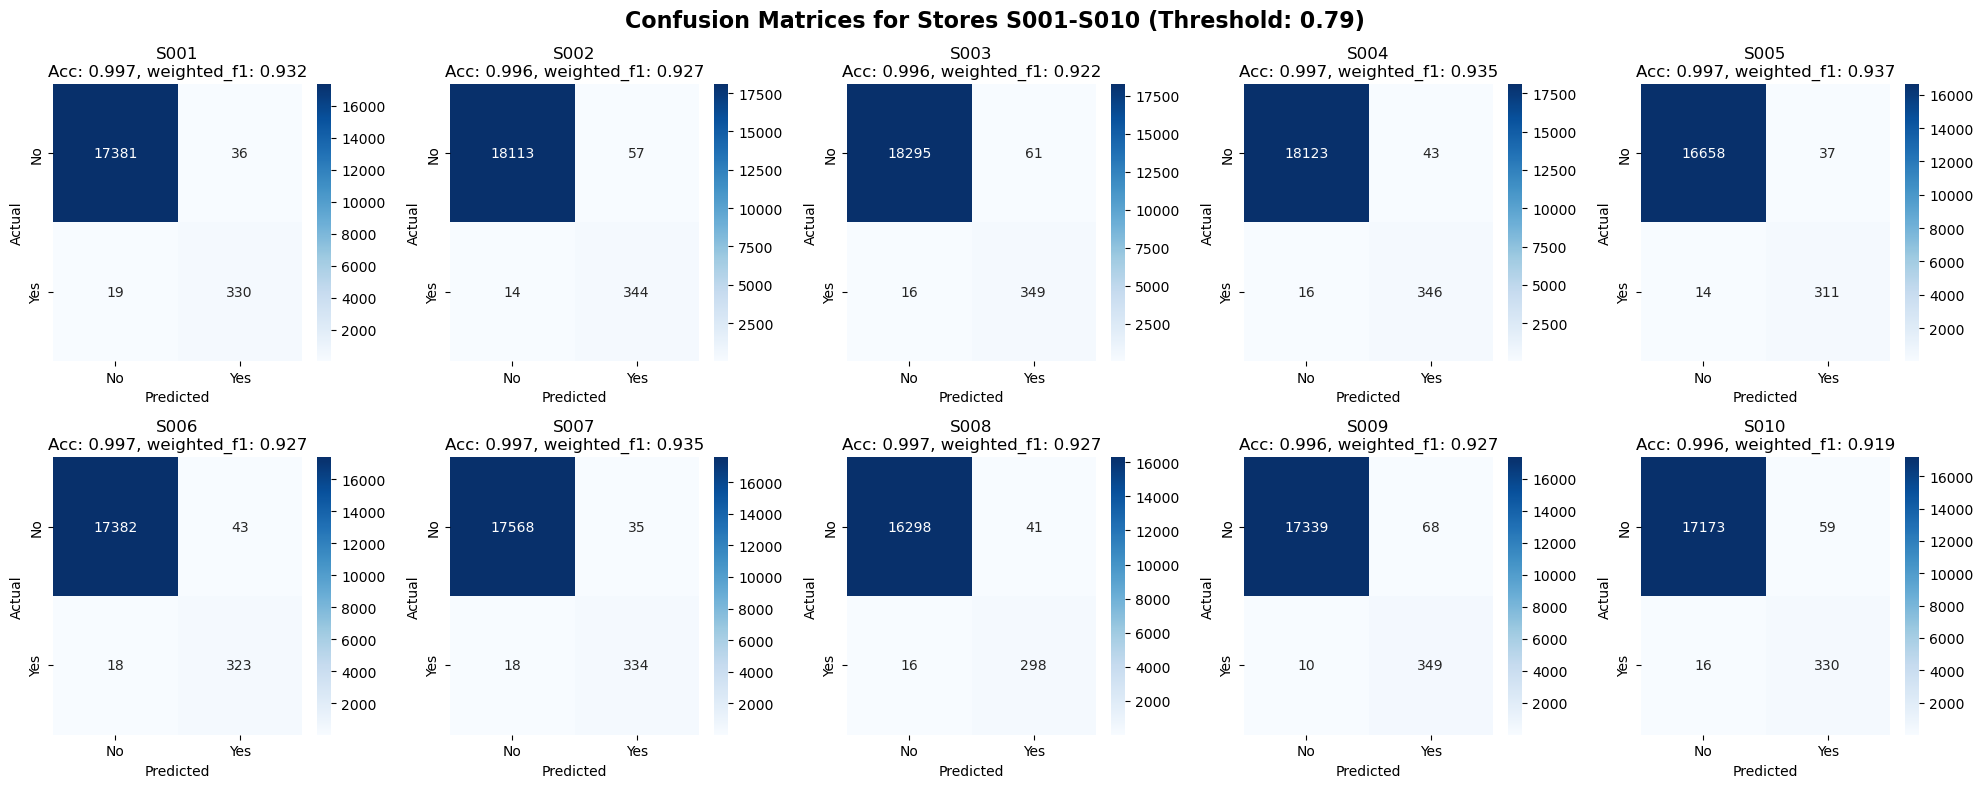

In [111]:
# Create visual confusion matrices
def plot_confusion_matrices(store_results, threshold):
    """Create visual confusion matrix plots for all stores"""
    
    # Calculate grid size
    n_stores = len(store_results)
    n_cols = 5  # 5 columns
    n_rows = (n_stores + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    fig.suptitle(f'Confusion Matrices for Stores S001-S010 (Threshold: {threshold})', 
                 fontsize=16, fontweight='bold')
    
    # Flatten axes array for easier indexing
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes_flat = axes.flatten()
    
    for i, result in enumerate(store_results):
        ax = axes_flat[i]
        cm = result['confusion_matrix']
        store_name = result['store']
        metrics = result['metrics']
        
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
        
        ax.set_title(f'{store_name}\nAcc: {metrics["accuracy"]:.3f}, weighted_f1: {metrics["weighted_f1_score"]:.3f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    # Hide unused subplots
    for i in range(len(store_results), len(axes_flat)):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Plot the confusion matrices
if all_store_results:
    print("Creating visual confusion matrices...")
    fig = plot_confusion_matrices(all_store_results, threshold)
else:
    print("No results available for plotting")


In [112]:
# Summary statistics for all stores
if all_store_results:
    print("\n=== DETAILED CONFUSION MATRIX SUMMARY ===")
    print(f"Threshold: {threshold}")
    print("-" * 80)
    
    # Create summary dataframe
    summary_data = []
    total_metrics = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'total_pairs': 0}
    
    for result in all_store_results:
        store = result['store']
        metrics = result['metrics']
        cm = result['confusion_matrix']
        
        summary_data.append({
            'Store': store,
            'True_Negatives': metrics['true_negatives'],
            'False_Positives': metrics['false_positives'],
            'False_Negatives': metrics['false_negatives'],
            'True_Positives': metrics['true_positives'],
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'weighted_f1': metrics['weighted_f1_score'],
            'Total_Pairs': metrics['total_pairs']
        })
        
        # Accumulate for overall metrics
        total_metrics['tn'] += metrics['true_negatives']
        total_metrics['fp'] += metrics['false_positives']
        total_metrics['fn'] += metrics['false_negatives']
        total_metrics['tp'] += metrics['true_positives']
        total_metrics['total_pairs'] += metrics['total_pairs']
    
    summary_df = pd.DataFrame(summary_data)
    
    # Display individual store results
    print("Individual Store Performance:")
    print(summary_df[['Store', 'True_Negatives', 'False_Positives', 'False_Negatives', 'True_Positives', 'Accuracy', 'Precision', 'Recall', 'weighted_f1']].round(3))

    # Calculate overall metrics
    overall_accuracy = (total_metrics['tp'] + total_metrics['tn']) / total_metrics['total_pairs']
    overall_precision = total_metrics['tp'] / (total_metrics['tp'] + total_metrics['fp']) if (total_metrics['tp'] + total_metrics['fp']) > 0 else 0
    overall_recall = total_metrics['tp'] / (total_metrics['tp'] + total_metrics['fn']) if (total_metrics['tp'] + total_metrics['fn']) > 0 else 0

    beta = (0.7 / 0.3) ** 0.5  # ≈ 1.53
    den = (beta**2) * overall_precision + overall_recall
    weighted_f1 = ((1 + beta**2) * overall_precision * overall_recall) / den if den > 0 else 0

    print(f"\n=== AGGREGATED PERFORMANCE ACROSS ALL STORES ===")
    print(f"Total product pairs analyzed: {total_metrics['total_pairs']:,}")
    print(f"True Negatives:  {total_metrics['tn']:,}")
    print(f"False Positives: {total_metrics['fp']:,}")
    print(f"False Negatives: {total_metrics['fn']:,}")
    print(f"True Positives:  {total_metrics['tp']:,}")
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:  {overall_accuracy:.3f}")
    print(f"  Precision: {overall_precision:.3f}")
    print(f"  Recall:    {overall_recall:.3f}")
    print(f"  weighted_f1-Score:  {weighted_f1:.3f}")

    # Average metrics across stores
    print(f"\n=== AVERAGE METRICS ACROSS STORES ===")
    print(f"  Average Accuracy:  {summary_df['Accuracy'].mean():.3f} ± {summary_df['Accuracy'].std():.3f}")
    print(f"  Average Precision: {summary_df['Precision'].mean():.3f} ± {summary_df['Precision'].std():.3f}")
    print(f"  Average Recall:    {summary_df['Recall'].mean():.3f} ± {summary_df['Recall'].std():.3f}")
    print(f"  Average weighted_f1-Score:  {summary_df['weighted_f1'].mean():.3f} ± {summary_df['weighted_f1'].std():.3f}")

    # Save detailed results
    summary_df.to_csv('confusion_matrix_summary_threshold_079.csv', index=False)
    print(f"\nDetailed results saved to: confusion_matrix_summary_threshold_079.csv")
else:
    print("No confusion matrix results available")



=== DETAILED CONFUSION MATRIX SUMMARY ===
Threshold: 0.79
--------------------------------------------------------------------------------
Individual Store Performance:
  Store  True_Negatives  False_Positives  False_Negatives  True_Positives  \
0  S001           17381               36               19             330   
1  S002           18113               57               14             344   
2  S003           18295               61               16             349   
3  S004           18123               43               16             346   
4  S005           16658               37               14             311   
5  S006           17382               43               18             323   
6  S007           17568               35               18             334   
7  S008           16298               41               16             298   
8  S009           17339               68               10             349   
9  S010           17173               59               16   

In [113]:
# 8. ANALYSIS FOR STORES S011 AND S015 (Threshold: 0.79)
print("=== APPLYING THRESHOLD 0.79 TO STORES S011 to S015 ===")
print("Analyzing additional stores...")

# Stores to analyze
additional_stores = ['S011', 'S012', 'S013', 'S014', 'S015']
threshold = 0.79

# Store results for these additional stores
additional_results = []

for store in additional_stores:
    print(f"\n--- {store} ---")
    result = create_confusion_matrix_for_store(store, threshold)
    
    if result:
        additional_results.append(result)
        cm = result['confusion_matrix']
        metrics = result['metrics']
        
        # Display confusion matrix
        print(f"Confusion Matrix:")
        print(f"                 Predicted")
        print(f"                No    Yes")
        print(f"Actual    No   {cm[0,0]:4d}  {cm[0,1]:4d}")
        print(f"         Yes   {cm[1,0]:4d}  {cm[1,1]:4d}")
        
        # Display metrics
        print(f"\nMetrics:")
        print(f"  Accuracy:  {metrics['accuracy']:.3f}")
        print(f"  Precision: {metrics['precision']:.3f}")
        print(f"  Recall:    {metrics['recall']:.3f}")
        print(f"  weighted_f1-Score:  {metrics['weighted_f1_score']:.3f}")
        print(f"  Total pairs with ground truth: {metrics['total_pairs']:,}")
        
        # Also categorize and save the data
        store_file = f'../NewData/StoresLevel/{store}.csv'
        store_df = pd.read_csv(store_file)
        store_df['substitutability_category'] = store_df['substitute_score'].apply(
            lambda score: 'Yes' if score >= threshold else 'No'
        )
        store_df['optimal_threshold'] = threshold
        
        # Save categorized results
        output_file = f'../NewData/StoresLevel/{store}_categorized.csv'
        store_df.to_csv(output_file, index=False)
        print(f"  Categorized data saved to: {output_file}")
        
        # Show distribution
        categories = store_df['substitutability_category'].value_counts()
        print(f"  Distribution in {store}:")
        for category, count in categories.items():
            percentage = (count / len(store_df)) * 100
            print(f"    {category}: {count:,} ({percentage:.1f}%)")
            
    else:
        print(f"Could not generate results for {store}")

print(f"\n{'='*80}")
print(f"Successfully analyzed {len(additional_results)} additional stores")


=== APPLYING THRESHOLD 0.79 TO STORES S011 to S015 ===
Analyzing additional stores...

--- S011 ---
Confusion Matrix:
                 Predicted
                No    Yes
Actual    No   17005    35
         Yes     24   327

Metrics:
  Accuracy:  0.997
  Precision: 0.903
  Recall:    0.932
  weighted_f1-Score:  0.923
  Total pairs with ground truth: 17,391
  Categorized data saved to: ../NewData/StoresLevel/S011_categorized.csv
  Distribution in S011:
    No: 17,029 (97.9%)
    Yes: 362 (2.1%)

--- S012 ---
Confusion Matrix:
                 Predicted
                No    Yes
Actual    No   15569    51
         Yes     20   291

Metrics:
  Accuracy:  0.996
  Precision: 0.851
  Recall:    0.936
  weighted_f1-Score:  0.909
  Total pairs with ground truth: 15,931
  Categorized data saved to: ../NewData/StoresLevel/S012_categorized.csv
  Distribution in S012:
    No: 15,589 (97.9%)
    Yes: 342 (2.1%)

--- S013 ---
Confusion Matrix:
                 Predicted
                No    Yes
Act

Creating visual confusion matrices for S011 and S015...


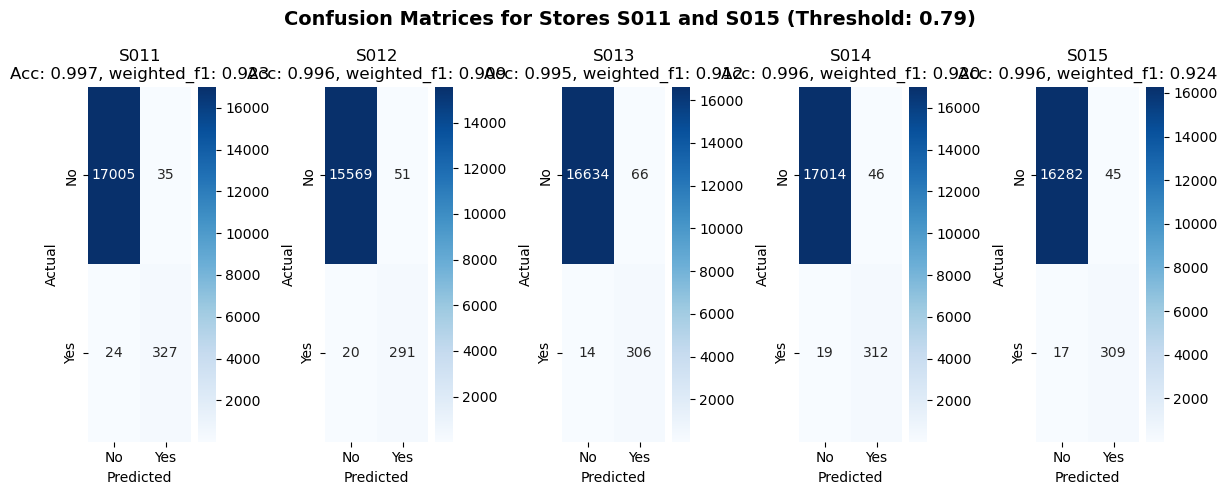


=== SUMMARY FOR S011 to S015 ===

S011:
  True Negatives:  17,005
  False Positives: 35
  False Negatives: 24
  True Positives:  327
  Accuracy:  0.997
  Precision: 0.903
  Recall:    0.932
  weighted_f1-Score:  0.923

S012:
  True Negatives:  15,569
  False Positives: 51
  False Negatives: 20
  True Positives:  291
  Accuracy:  0.996
  Precision: 0.851
  Recall:    0.936
  weighted_f1-Score:  0.909

S013:
  True Negatives:  16,634
  False Positives: 66
  False Negatives: 14
  True Positives:  306
  Accuracy:  0.995
  Precision: 0.823
  Recall:    0.956
  weighted_f1-Score:  0.912

S014:
  True Negatives:  17,014
  False Positives: 46
  False Negatives: 19
  True Positives:  312
  Accuracy:  0.996
  Precision: 0.872
  Recall:    0.943
  weighted_f1-Score:  0.920

S015:
  True Negatives:  16,282
  False Positives: 45
  False Negatives: 17
  True Positives:  309
  Accuracy:  0.996
  Precision: 0.873
  Recall:    0.948
  weighted_f1-Score:  0.924


In [114]:
# Visual confusion matrices for S011 and S015
if additional_results:
    print("Creating visual confusion matrices for S011 and S015...")
    
    # Create figure for additional stores
    fig, axes = plt.subplots(1, 5, figsize=(12, 5))
    fig.suptitle(f'Confusion Matrices for Stores S011 and S015 (Threshold: {threshold})', 
                 fontsize=14, fontweight='bold')
    
    for i, result in enumerate(additional_results):
        ax = axes[i]
        cm = result['confusion_matrix']
        store_name = result['store']
        metrics = result['metrics']
        
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])

        ax.set_title(f'{store_name}\nAcc: {metrics["accuracy"]:.3f}, weighted_f1: {metrics["weighted_f1_score"]:.3f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Summary for additional stores
    print(f"\n=== SUMMARY FOR S011 to S015 ===")
    for result in additional_results:
        store = result['store']
        metrics = result['metrics']
        print(f"\n{store}:")
        print(f"  True Negatives:  {metrics['true_negatives']:,}")
        print(f"  False Positives: {metrics['false_positives']:,}")
        print(f"  False Negatives: {metrics['false_negatives']:,}")
        print(f"  True Positives:  {metrics['true_positives']:,}")
        print(f"  Accuracy:  {metrics['accuracy']:.3f}")
        print(f"  Precision: {metrics['precision']:.3f}")
        print(f"  Recall:    {metrics['recall']:.3f}")
        print(f"  weighted_f1-Score:  {metrics['weighted_f1_score']:.3f}")

else:
    print("No results available for S011 to S015")


In [115]:
# Combined analysis: S001-S010 + S011 + S015
if additional_results and all_store_results:
    print("=== COMBINED ANALYSIS: ALL STORES (S001-S015) ===")
    
    # Combine all results
    combined_results = all_store_results + additional_results
    
    # Create comprehensive summary
    combined_summary_data = []
    combined_total_metrics = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'total_pairs': 0}
    
    for result in combined_results:
        store = result['store']
        metrics = result['metrics']
        
        combined_summary_data.append({
            'Store': store,
            'True_Negatives': metrics['true_negatives'],
            'False_Positives': metrics['false_positives'],
            'False_Negatives': metrics['false_negatives'],
            'True_Positives': metrics['true_positives'],
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'weighted_f1': metrics['weighted_f1_score'],
            'Total_Pairs': metrics['total_pairs']
        })
        
        # Accumulate for overall metrics
        combined_total_metrics['tn'] += metrics['true_negatives']
        combined_total_metrics['fp'] += metrics['false_positives']
        combined_total_metrics['fn'] += metrics['false_negatives']
        combined_total_metrics['tp'] += metrics['true_positives']
        combined_total_metrics['total_pairs'] += metrics['total_pairs']
    
    combined_summary_df = pd.DataFrame(combined_summary_data)
    
    print(f"\nAll Stores Performance (Threshold: {threshold}):")
    print(combined_summary_df[['Store', 'Accuracy', 'Precision', 'Recall', 'weighted_f1', 'Total_Pairs']].round(3))
    
    # Calculate combined overall metrics
    combined_accuracy = (combined_total_metrics['tp'] + combined_total_metrics['tn']) / combined_total_metrics['total_pairs']
    combined_precision = combined_total_metrics['tp'] / (combined_total_metrics['tp'] + combined_total_metrics['fp']) if (combined_total_metrics['tp'] + combined_total_metrics['fp']) > 0 else 0
    combined_recall = combined_total_metrics['tp'] / (combined_total_metrics['tp'] + combined_total_metrics['fn']) if (combined_total_metrics['tp'] + combined_total_metrics['fn']) > 0 else 0
    combined_f1 = 2 * (combined_precision * combined_recall) / (combined_precision + combined_recall) if (combined_precision + combined_recall) > 0 else 0
    
    print(f"\n=== FINAL AGGREGATED PERFORMANCE (S001-S015) ===")
    print(f"Total stores analyzed: {len(combined_results)}")
    print(f"Total product pairs: {combined_total_metrics['total_pairs']:,}")
    print(f"True Negatives:  {combined_total_metrics['tn']:,}")
    print(f"False Positives: {combined_total_metrics['fp']:,}")
    print(f"False Negatives: {combined_total_metrics['fn']:,}")
    print(f"True Positives:  {combined_total_metrics['tp']:,}")
    print(f"\nCombined Overall Metrics:")
    print(f"  Accuracy:  {combined_accuracy:.3f}")
    print(f"  Precision: {combined_precision:.3f}")
    print(f"  Recall:    {combined_recall:.3f}")
    print(f"  F1-Score:  {combined_f1:.3f}")
    
    # Save complete results
    combined_summary_df.to_csv('complete_confusion_matrix_summary_threshold_079.csv', index=False)
    print(f"\nComplete results saved to: complete_confusion_matrix_summary_threshold_079.csv")
    
    print(f"\n🎯 ANALYSIS COMPLETE!")
    print(f"Successfully analyzed {len(combined_results)} stores (S001-S010, S011, S015) using threshold 0.79")

else:
    print("Combined analysis not available - missing data from previous steps")


=== COMBINED ANALYSIS: ALL STORES (S001-S015) ===

All Stores Performance (Threshold: 0.79):
   Store  Accuracy  Precision  Recall  weighted_f1  Total_Pairs
0   S001     0.997      0.902   0.946        0.932        17766
1   S002     0.996      0.858   0.961        0.927        18528
2   S003     0.996      0.851   0.956        0.922        18721
3   S004     0.997      0.889   0.956        0.935        18528
4   S005     0.997      0.894   0.957        0.937        17020
5   S006     0.997      0.883   0.947        0.927        17766
6   S007     0.997      0.905   0.949        0.935        17955
7   S008     0.997      0.879   0.949        0.927        16653
8   S009     0.996      0.837   0.972        0.927        17766
9   S010     0.996      0.848   0.954        0.919        17578
10  S011     0.997      0.903   0.932        0.923        17391
11  S012     0.996      0.851   0.936        0.909        15931
12  S013     0.995      0.823   0.956        0.912        17020
13  S014   

In [116]:
# Calculate and print combined metrics for S011 to S015
if 'combined_results' in locals():
    # Filter the combined_results for S011 to S015
    stores_to_combine = [f"S{str(i).zfill(3)}" for i in range(1, 11)]
    filtered_results = [res for res in combined_results if res['store'] in stores_to_combine]

    if filtered_results:
        print(f"\n=== COMBINED PERFORMANCE: S001 to S010 ===")
        print(f"Found {len(filtered_results)} stores: {[res['store'] for res in filtered_results]}")
        
        # Sum confusion matrix components using correct dictionary access
        total_tn = sum(res['metrics']['true_negatives'] for res in filtered_results)
        total_fp = sum(res['metrics']['false_positives'] for res in filtered_results)
        total_fn = sum(res['metrics']['false_negatives'] for res in filtered_results)
        total_tp = sum(res['metrics']['true_positives'] for res in filtered_results)
        total_pairs = sum(res['metrics']['total_pairs'] for res in filtered_results)

        # Calculate metrics
        accuracy = (total_tp + total_tn) / total_pairs if total_pairs > 0 else 0
        precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
        recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
        beta = (0.7 / 0.3) ** 0.5
        den = (beta**2) * precision + recall
        weighted_f1 = ((1 + beta**2) * precision * recall) / den if den > 0 else 0
        

        print(f"Total product pairs: {total_pairs:,}")
        print(f"True Negatives:  {total_tn:,}")
        print(f"False Positives: {total_fp:,}")
        print(f"False Negatives: {total_fn:,}")
        print(f"True Positives:  {total_tp:,}")
        print(f"\nCombined Metrics for S001 to S010:")
        print(f"  Accuracy:  {accuracy:.3f}")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall:    {recall:.3f}")
        print(f"  weighted_f1-Score:  {weighted_f1:.3f}")
    else:
        print("No stores S001 to S010 found in combined results.")
        print("Available stores:", [res['store'] for res in combined_results] if 'combined_results' in locals() else "No combined_results found")
else:
    print("combined_results variable not found. Please run the previous cells first.")



=== COMBINED PERFORMANCE: S001 to S010 ===
Found 10 stores: ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010']
Total product pairs: 178,281
True Negatives:  174,330
False Positives: 480
False Negatives: 157
True Positives:  3,314

Combined Metrics for S001 to S010:
  Accuracy:  0.996
  Precision: 0.873
  Recall:    0.955
  weighted_f1-Score:  0.929


In [117]:
# Calculate and print combined metrics for S011 to S015
if 'combined_results' in locals():
    # Filter the combined_results for S011 to S015
    stores_to_combine = [f"S{str(i).zfill(3)}" for i in range(11, 16)]
    filtered_results = [res for res in combined_results if res['store'] in stores_to_combine]

    if filtered_results:
        print(f"\n=== COMBINED PERFORMANCE: S011 to S015 ===")
        print(f"Found {len(filtered_results)} stores: {[res['store'] for res in filtered_results]}")
        
        # Sum confusion matrix components using correct dictionary access
        total_tn = sum(res['metrics']['true_negatives'] for res in filtered_results)
        total_fp = sum(res['metrics']['false_positives'] for res in filtered_results)
        total_fn = sum(res['metrics']['false_negatives'] for res in filtered_results)
        total_tp = sum(res['metrics']['true_positives'] for res in filtered_results)
        total_pairs = sum(res['metrics']['total_pairs'] for res in filtered_results)

        # Calculate metrics
        accuracy = (total_tp + total_tn) / total_pairs if total_pairs > 0 else 0
        precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
        recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
        beta = (0.7 / 0.3) ** 0.5
        den = (beta**2) * precision + recall
        weighted_f1 = ((1 + beta**2) * precision * recall) / den if den > 0 else 0
        

        print(f"Total product pairs: {total_pairs:,}")
        print(f"True Negatives:  {total_tn:,}")
        print(f"False Positives: {total_fp:,}")
        print(f"False Negatives: {total_fn:,}")
        print(f"True Positives:  {total_tp:,}")
        print(f"\nCombined Metrics for S011 to S015:")
        print(f"  Accuracy:  {accuracy:.3f}")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall:    {recall:.3f}")
        print(f"  weighted_f1-Score:  {weighted_f1:.3f}")
    else:
        print("No stores S011-S015 found in combined results.")
        print("Available stores:", [res['store'] for res in combined_results] if 'combined_results' in locals() else "No combined_results found")
else:
    print("combined_results variable not found. Please run the previous cells first.")



=== COMBINED PERFORMANCE: S011 to S015 ===
Found 5 stores: ['S011', 'S012', 'S013', 'S014', 'S015']
Total product pairs: 84,386
True Negatives:  82,504
False Positives: 243
False Negatives: 94
True Positives:  1,545

Combined Metrics for S011 to S015:
  Accuracy:  0.996
  Precision: 0.864
  Recall:    0.943
  weighted_f1-Score:  0.918
